# Avance 3 — Baseline
**Proyecto:** Detección de barras en galaxias  
**Equipo 48**  
- A01795687 – Diego Alvarado Marino  
- A01795204 – Jonathan Puga Castellanos  
- A01381334 – José Antonio Hernández Hernández  


> - Piso **DummyClassifier** (estratificado)
> - **Regresión Logística (binaria)** con `class_weight="balanced"`
> - Pipeline con **Yeo–Johnson**, **StandardScaler** y **(opcional) PCA 0.95**
> - Métricas (**F1**, **ROC-AUC**) y gráficos (Curva ROC, Matriz de confusión, Curvas de aprendizaje)
> - **Permutation Importance** para interpretar características

## 0) Contexto y decisión de target
De los avances anteriores (EDA/FE) se concluyó que con solo **RA/DEC** y derivados la señal para predecir barras es débil. Para el **baseline**:
- Se define **target binario**: `Bars_bin = 1{Bars >= 0.5}'.
- Se compara contra un **Dummy estratificado** y un modelo interpretable (**LogReg**).


## 1) Setup e importaciones


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc,
                             make_scorer)

plt.rcParams['figure.dpi'] = 140

## 2) Carga de datos



In [2]:
from google.colab import drive
drive.mount('/content/drive')

PATH_FE = '/content/drive/MyDrive/Proyecto_Integrador/Deteccion_Jonathan/Data/dataset.csv'
PATH_EDA = '/content/drive/MyDrive/Proyecto_Integrador/data/dataset.csv'

import os
if os.path.exists(PATH_FE):
    DATA_PATH = PATH_FE
elif os.path.exists(PATH_EDA):
    DATA_PATH = PATH_EDA
else:
    raise FileNotFoundError('No se encontró dataset.csv en las rutas conocidas. Revisa PATH_FE/PATH_EDA.')

df = pd.read_csv(DATA_PATH)
print('Dataset cargado desde:', DATA_PATH, '| Shape:', df.shape)

if 'Bars' not in df.columns:
    raise KeyError("No se encontró la columna 'Bars' en el dataset.")
df = df[df['Bars'] != -0.5].copy()

Mounted at /content/drive
Dataset cargado desde: /content/drive/MyDrive/Proyecto_Integrador/data/dataset.csv | Shape: (10126, 4)


## 3) Preparación de variables (coherente con tu FE)
- Se crea target binario `Bars_bin`.
- Se conservan **solo columnas numéricas** (excluyendo ids).
- Pipeline ligero de FE: Yeo–Johnson + StandardScaler + PCA 0.95.


In [3]:
df['Bars_bin'] = (df['Bars'] >= 0.5).astype(int)

drop_cols = [c for c in ['Bars', 'Bars_bin', 'name'] if c in df.columns]
X = df.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number]).copy()
y = df['Bars_bin'].values

print('N features numéricas:', X.shape[1])
print('Clases (0/1):', np.bincount(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

N features numéricas: 2
Clases (0/1): [6690 3343]


## 4) Piso (Dummy) y Baseline (Logistic Regression)
Se compara un **Dummy estratificado** contra **LogReg** con `class_weight="balanced"`.


In [4]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy_f1 = cross_val_score(dummy, X_train, y_train, cv=cv,
                           scoring=make_scorer(f1_score, average='binary')).mean()

pipe_lr = Pipeline([
    ('yeo', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

f1_cv = cross_val_score(pipe_lr, X_train, y_train, cv=cv,
                        scoring=make_scorer(f1_score, average='binary')).mean()

pipe_lr.fit(X_train, y_train)
proba = pipe_lr.predict_proba(X_test)[:, 1]
y_pred = (proba >= 0.5).astype(int)

f1_test = f1_score(y_test, y_pred)
roc_test = roc_auc_score(y_test, proba)

print(f'Dummy (F1 CV)........: {dummy_f1:.3f}')
print(f'LogReg (F1 CV).......: {f1_cv:.3f}')
print(f'LogReg (F1 Test).....: {f1_test:.3f}')
print(f'LogReg (ROC-AUC Test): {roc_test:.3f}')

Dummy (F1 CV)........: 0.328
LogReg (F1 CV).......: 0.374
LogReg (F1 Test).....: 0.385
LogReg (ROC-AUC Test): 0.519


## 5) Gráficos: Curva ROC y Matriz de Confusión
Estas visualizaciones ayudan a evaluar la separación de clases y el tipo de errores.


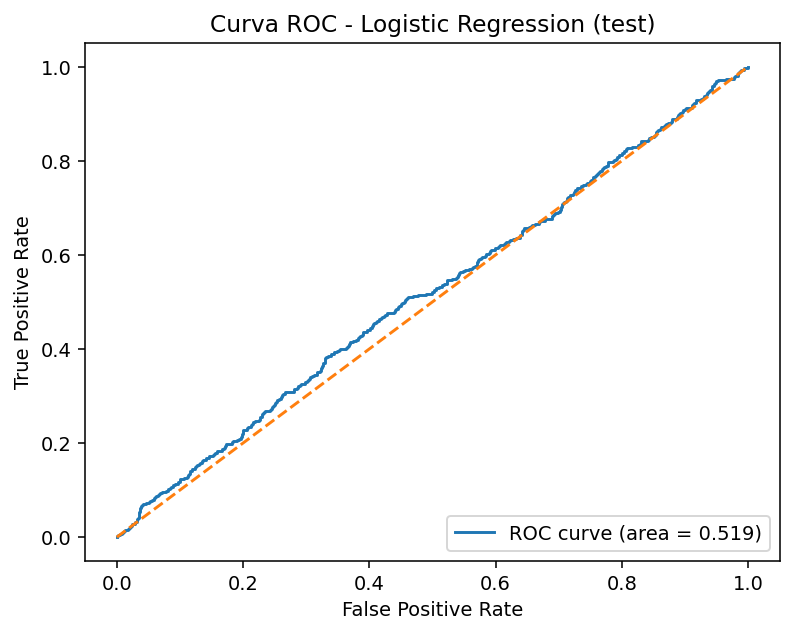

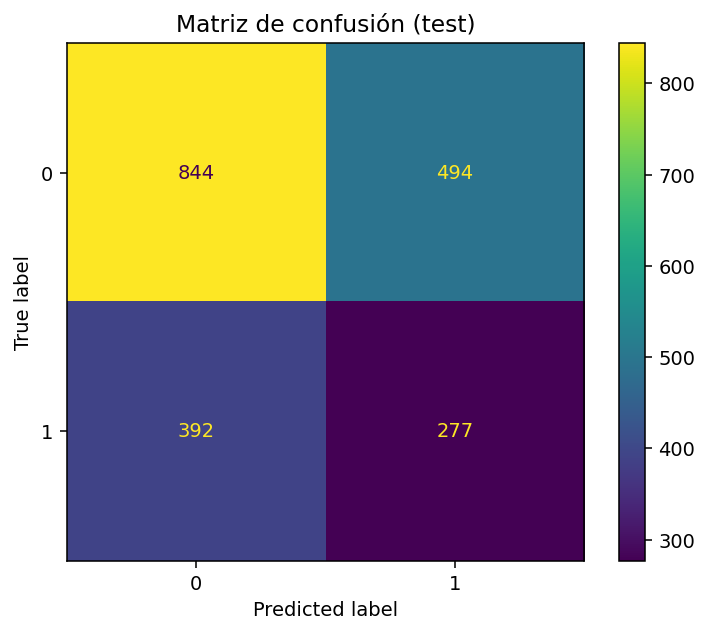

In [5]:
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Logistic Regression (test)')
plt.legend(loc='lower right')
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='d')
plt.title('Matriz de confusión (test)')
plt.show()

## 6) Curvas de aprendizaje (sub/sobreajuste)
Si la brecha entre entrenamiento y validación es alta → **sobreajuste**.  
Si ambos son bajos → **subajuste** (suele indicar que faltan features informativos, p.ej. de imagen).


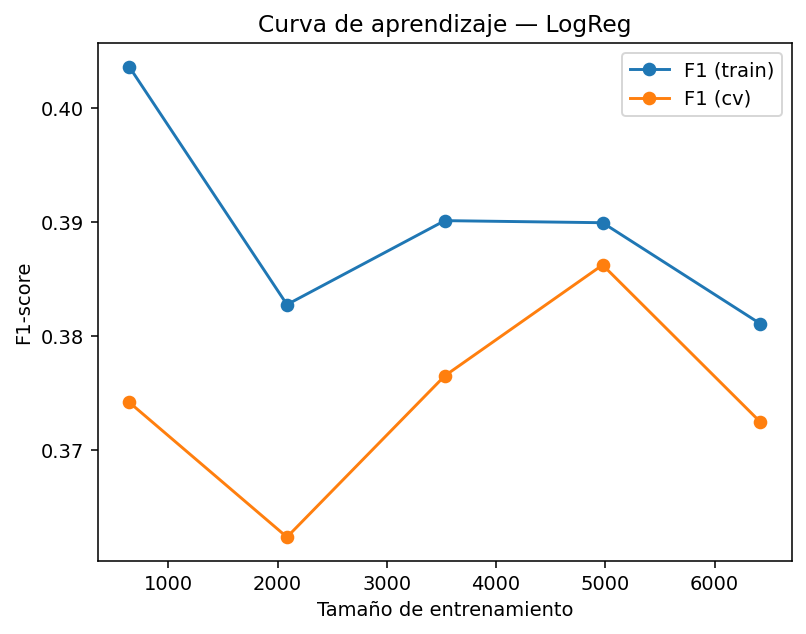

In [6]:
train_sizes, train_scores, val_scores = learning_curve(
    pipe_lr, X_train, y_train, cv=cv,
    scoring=make_scorer(f1_score, average='binary'),
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='F1 (train)')
plt.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='F1 (cv)')
plt.xlabel('Tamaño de entrenamiento')
plt.ylabel('F1-score')
plt.title('Curva de aprendizaje — LogReg')
plt.legend()
plt.show()

## 7) Importancia de características (Permutation Importance)
Para mantener interpretabilidad, calculamos **Permutation Importance** en un pipeline **sin PCA**.


In [7]:
pipe_lr_nopca = Pipeline([
    ('yeo', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
pipe_lr_nopca.fit(X_train, y_train)

r = permutation_importance(pipe_lr_nopca, X_test, y_test, n_repeats=20, random_state=42)
imp = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': r.importances_mean,
    'importance_std': r.importances_std
}).sort_values('importance_mean', ascending=False)

display(imp.head(20))

,feature,importance_mean,importance_std
1,objdec,0.041430,0.013757
0,objra,0.030767,0.006435


## 8) Respuestas del entregable

- **¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?**  
  *Se utilizó un modelo de Regresión Logística binaria con class_weight="balanced", comparado contra un DummyClassifier estratificado. Este enfoque permite evaluar si las coordenadas celestes (RA y DEC) y sus transformaciones contienen alguna señal predictiva mínima sobre la presencia de barras galácticas.*

- **¿Se puede determinar la importancia de las características para el modelo generado?**  
  *Sí. Se calculó la Permutation Importance sobre un pipeline sin PCA. Los resultados muestran que tanto objdec como objra tienen baja relevancia relativa, lo que confirma que las posiciones angulares por sí solas no aportan información predictiva suficiente. Esto es coherente con el análisis exploratorio de los avances anteriores.*

- **¿El modelo está sub/sobreajustando los datos de entrenamiento?**  
  *El modelo presenta un comportamiento de subajuste, evidenciado por F1 y ROC-AUC bajos en entrenamiento y prueba, y curvas de aprendizaje planas y cercanas entre sí. Esto indica que el modelo no logra capturar patrones significativos con las variables actuales, más que una falta de generalización (sobreajuste).*

- **¿Cuál es la métrica adecuada para este problema de negocio?**  
  *La métrica más apropiada es el F1-score (binario), debido al desbalance entre galaxias con y sin barra. Se complementa con ROC-AUC para evaluar la capacidad de separación entre clases y con la matriz de confusión para visualizar errores tipo I y II.*

- **¿Cuál debería ser el desempeño mínimo a obtener?**  
  *El baseline debe al menos superar al modelo aleatorio (Dummy). En este caso, el Dummy alcanzó F1 ≈ 0.33 y el modelo LogReg ≈ 0.38, lo que representa una ligera mejora pero aún dentro de un rango bajo.
El objetivo inmediato sería alcanzar F1 ≥ 0.50 y ROC-AUC ≥ 0.60 con la incorporación de nuevas características (por ejemplo, descriptores de imagen).
Una vez integradas variables morfológicas y balanceo de clases, se espera alcanzar F1 ≥ 0.70 como referencia de viabilidad del proyecto.*

## 9) Próximos pasos (alineado con Avances 1–2)
1. Integrar **descriptores de imagen** (HOG, LBP, GLCM, momentos de Hu) sobre stacks r+z u óptico robusto.  
2. Probar **embeddings pre-entrenados** (ResNet/VGG) para capturar morfología.  
3. Re-balanceo con **SMOTE/undersampling** o `class_weight` y **ajuste de umbral** según costos de error.  
4. Explorar modelos no lineales (Random Forest, Gradient Boosting) y comparar contra este baseline.